In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import time
import copy
import os

In [2]:
batch_size = 64
learning_rate = 1e-3

transforms = transforms.Compose(
[
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root='emotion5/train/', transform=transforms)
test_dataset = datasets.ImageFolder(root='emotion5/test/', transform=transforms)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
def imshow(inp, title=None):
    
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

images-size: torch.Size([64, 3, 48, 48])
out-size: torch.Size([3, 402, 402])


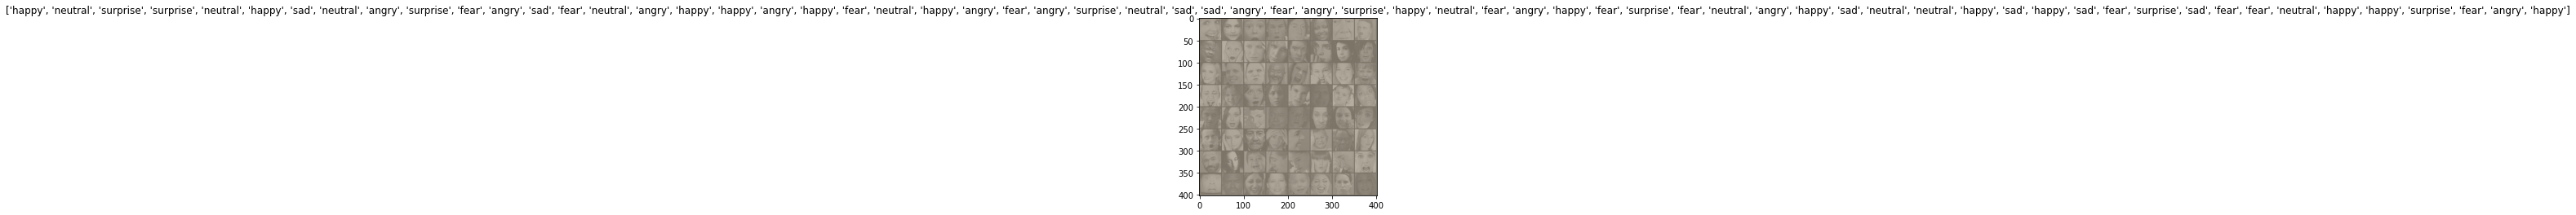

In [4]:
images, labels = next(iter(train_dataloader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

imshow(out, title=[train_dataset.classes[x] for x in labels])

In [5]:
net = models.resnet50(pretrained=True)
net = net.cuda() if device else net
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, 
                 betas=(0.9, 0.999), 
                 eps=1e-08, 
                 weight_decay=0, 
                 amsgrad=False)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 128)
net.fc = net.fc.cuda() if device else net.fc

In [7]:
n_epochs = 150
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet_adam_batch64_lr00001.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/150], Step [0/442], Loss: 4.8455
Epoch [1/150], Step [20/442], Loss: 2.8072
Epoch [1/150], Step [40/442], Loss: 2.2210
Epoch [1/150], Step [60/442], Loss: 1.8799
Epoch [1/150], Step [80/442], Loss: 1.7474
Epoch [1/150], Step [100/442], Loss: 1.4777
Epoch [1/150], Step [120/442], Loss: 1.7349
Epoch [1/150], Step [140/442], Loss: 1.3192
Epoch [1/150], Step [160/442], Loss: 1.5388
Epoch [1/150], Step [180/442], Loss: 1.2789
Epoch [1/150], Step [200/442], Loss: 1.3102
Epoch [1/150], Step [220/442], Loss: 1.3829
Epoch [1/150], Step [240/442], Loss: 1.2829
Epoch [1/150], Step [260/442], Loss: 1.5912
Epoch [1/150], Step [280/442], Loss: 1.0584
Epoch [1/150], Step [300/442], Loss: 1.2169
Epoch [1/150], Step [320/442], Loss: 1.1456
Epoch [1/150], Step [340/442], Loss: 1.2429
Epoch [1/150], Step [360/442], Loss: 1.5813
Epoch [1/150], Step [380/442], Loss: 1.0284
Epoch [1/150], Step [400/442], Loss: 1.5699
Epoch [1/150], Step [420/442], Loss: 1.1178
Epoch [1/150], Step [440/442]

Epoch [8/150], Step [160/442], Loss: 0.6291
Epoch [8/150], Step [180/442], Loss: 0.5360
Epoch [8/150], Step [200/442], Loss: 0.6145
Epoch [8/150], Step [220/442], Loss: 0.4554
Epoch [8/150], Step [240/442], Loss: 0.6808
Epoch [8/150], Step [260/442], Loss: 0.5201
Epoch [8/150], Step [280/442], Loss: 0.4422
Epoch [8/150], Step [300/442], Loss: 0.4174
Epoch [8/150], Step [320/442], Loss: 0.4881
Epoch [8/150], Step [340/442], Loss: 0.4688
Epoch [8/150], Step [360/442], Loss: 0.5557
Epoch [8/150], Step [380/442], Loss: 0.7530
Epoch [8/150], Step [400/442], Loss: 0.5559
Epoch [8/150], Step [420/442], Loss: 0.5294
Epoch [8/150], Step [440/442], Loss: 0.7752

train-loss: 0.9135, train-acc: 80.8475
validation loss: 1.2905, validation acc: 58.9784

Epoch 9

Epoch [9/150], Step [0/442], Loss: 0.3915
Epoch [9/150], Step [20/442], Loss: 0.4075
Epoch [9/150], Step [40/442], Loss: 0.2347
Epoch [9/150], Step [60/442], Loss: 0.3033
Epoch [9/150], Step [80/442], Loss: 0.3269
Epoch [9/150], Step [100/44

Epoch [15/150], Step [320/442], Loss: 0.1267
Epoch [15/150], Step [340/442], Loss: 0.2121
Epoch [15/150], Step [360/442], Loss: 0.2653
Epoch [15/150], Step [380/442], Loss: 0.1944
Epoch [15/150], Step [400/442], Loss: 0.1508
Epoch [15/150], Step [420/442], Loss: 0.0835
Epoch [15/150], Step [440/442], Loss: 0.1765

train-loss: 0.6080, train-acc: 94.8467
validation loss: 1.4170, validation acc: 61.0160

Epoch 16

Epoch [16/150], Step [0/442], Loss: 0.0873
Epoch [16/150], Step [20/442], Loss: 0.1100
Epoch [16/150], Step [40/442], Loss: 0.1612
Epoch [16/150], Step [60/442], Loss: 0.0673
Epoch [16/150], Step [80/442], Loss: 0.1801
Epoch [16/150], Step [100/442], Loss: 0.1372
Epoch [16/150], Step [120/442], Loss: 0.1400
Epoch [16/150], Step [140/442], Loss: 0.1181
Epoch [16/150], Step [160/442], Loss: 0.1032
Epoch [16/150], Step [180/442], Loss: 0.0703
Epoch [16/150], Step [200/442], Loss: 0.1520
Epoch [16/150], Step [220/442], Loss: 0.1635
Epoch [16/150], Step [240/442], Loss: 0.2078
Epoch 

validation loss: 1.5509, validation acc: 61.8933

Epoch 23

Epoch [23/150], Step [0/442], Loss: 0.0279
Epoch [23/150], Step [20/442], Loss: 0.0176
Epoch [23/150], Step [40/442], Loss: 0.0519
Epoch [23/150], Step [60/442], Loss: 0.0804
Epoch [23/150], Step [80/442], Loss: 0.0340
Epoch [23/150], Step [100/442], Loss: 0.0213
Epoch [23/150], Step [120/442], Loss: 0.1983
Epoch [23/150], Step [140/442], Loss: 0.0802
Epoch [23/150], Step [160/442], Loss: 0.1704
Epoch [23/150], Step [180/442], Loss: 0.0734
Epoch [23/150], Step [200/442], Loss: 0.1382
Epoch [23/150], Step [220/442], Loss: 0.0324
Epoch [23/150], Step [240/442], Loss: 0.1280
Epoch [23/150], Step [260/442], Loss: 0.1026
Epoch [23/150], Step [280/442], Loss: 0.0417
Epoch [23/150], Step [300/442], Loss: 0.1037
Epoch [23/150], Step [320/442], Loss: 0.0511
Epoch [23/150], Step [340/442], Loss: 0.1276
Epoch [23/150], Step [360/442], Loss: 0.1703
Epoch [23/150], Step [380/442], Loss: 0.1197
Epoch [23/150], Step [400/442], Loss: 0.0747
E

Epoch [30/150], Step [120/442], Loss: 0.0158
Epoch [30/150], Step [140/442], Loss: 0.1140
Epoch [30/150], Step [160/442], Loss: 0.0302
Epoch [30/150], Step [180/442], Loss: 0.0561
Epoch [30/150], Step [200/442], Loss: 0.0997
Epoch [30/150], Step [220/442], Loss: 0.0617
Epoch [30/150], Step [240/442], Loss: 0.1331
Epoch [30/150], Step [260/442], Loss: 0.0485
Epoch [30/150], Step [280/442], Loss: 0.1675
Epoch [30/150], Step [300/442], Loss: 0.1522
Epoch [30/150], Step [320/442], Loss: 0.0312
Epoch [30/150], Step [340/442], Loss: 0.1742
Epoch [30/150], Step [360/442], Loss: 0.0453
Epoch [30/150], Step [380/442], Loss: 0.1383
Epoch [30/150], Step [400/442], Loss: 0.0742
Epoch [30/150], Step [420/442], Loss: 0.1089
Epoch [30/150], Step [440/442], Loss: 0.1055

train-loss: 0.3529, train-acc: 97.1280
validation loss: 1.6816, validation acc: 60.1811

Epoch 31

Epoch [31/150], Step [0/442], Loss: 0.0177
Epoch [31/150], Step [20/442], Loss: 0.0567
Epoch [31/150], Step [40/442], Loss: 0.0626
Epoc

Epoch [37/150], Step [260/442], Loss: 0.0636
Epoch [37/150], Step [280/442], Loss: 0.0574
Epoch [37/150], Step [300/442], Loss: 0.0089
Epoch [37/150], Step [320/442], Loss: 0.1487
Epoch [37/150], Step [340/442], Loss: 0.1360
Epoch [37/150], Step [360/442], Loss: 0.0740
Epoch [37/150], Step [380/442], Loss: 0.0431
Epoch [37/150], Step [400/442], Loss: 0.0302
Epoch [37/150], Step [420/442], Loss: 0.3460
Epoch [37/150], Step [440/442], Loss: 0.1001

train-loss: 0.2976, train-acc: 98.1643
validation loss: 1.7657, validation acc: 62.0348

Epoch 38

Epoch [38/150], Step [0/442], Loss: 0.0445
Epoch [38/150], Step [20/442], Loss: 0.0074
Epoch [38/150], Step [40/442], Loss: 0.0092
Epoch [38/150], Step [60/442], Loss: 0.0068
Epoch [38/150], Step [80/442], Loss: 0.0138
Epoch [38/150], Step [100/442], Loss: 0.0657
Epoch [38/150], Step [120/442], Loss: 0.0183
Epoch [38/150], Step [140/442], Loss: 0.0732
Epoch [38/150], Step [160/442], Loss: 0.0308
Epoch [38/150], Step [180/442], Loss: 0.0252
Epoch 

Epoch [44/150], Step [400/442], Loss: 0.0259
Epoch [44/150], Step [420/442], Loss: 0.0111
Epoch [44/150], Step [440/442], Loss: 0.2311

train-loss: 0.2588, train-acc: 97.8460
validation loss: 1.8380, validation acc: 60.1245

Epoch 45

Epoch [45/150], Step [0/442], Loss: 0.0526
Epoch [45/150], Step [20/442], Loss: 0.0625
Epoch [45/150], Step [40/442], Loss: 0.0421
Epoch [45/150], Step [60/442], Loss: 0.0316
Epoch [45/150], Step [80/442], Loss: 0.0136
Epoch [45/150], Step [100/442], Loss: 0.0083
Epoch [45/150], Step [120/442], Loss: 0.0811
Epoch [45/150], Step [140/442], Loss: 0.0178
Epoch [45/150], Step [160/442], Loss: 0.0078
Epoch [45/150], Step [180/442], Loss: 0.0395
Epoch [45/150], Step [200/442], Loss: 0.0768
Epoch [45/150], Step [220/442], Loss: 0.0277
Epoch [45/150], Step [240/442], Loss: 0.0054
Epoch [45/150], Step [260/442], Loss: 0.0556
Epoch [45/150], Step [280/442], Loss: 0.0737
Epoch [45/150], Step [300/442], Loss: 0.0394
Epoch [45/150], Step [320/442], Loss: 0.0137
Epoch 

Epoch [52/150], Step [40/442], Loss: 0.0082
Epoch [52/150], Step [60/442], Loss: 0.0046
Epoch [52/150], Step [80/442], Loss: 0.0258
Epoch [52/150], Step [100/442], Loss: 0.0183
Epoch [52/150], Step [120/442], Loss: 0.0265
Epoch [52/150], Step [140/442], Loss: 0.0080
Epoch [52/150], Step [160/442], Loss: 0.0073
Epoch [52/150], Step [180/442], Loss: 0.0396
Epoch [52/150], Step [200/442], Loss: 0.0259
Epoch [52/150], Step [220/442], Loss: 0.0349
Epoch [52/150], Step [240/442], Loss: 0.0424
Epoch [52/150], Step [260/442], Loss: 0.0789
Epoch [52/150], Step [280/442], Loss: 0.0110
Epoch [52/150], Step [300/442], Loss: 0.0361
Epoch [52/150], Step [320/442], Loss: 0.1406
Epoch [52/150], Step [340/442], Loss: 0.0032
Epoch [52/150], Step [360/442], Loss: 0.0136
Epoch [52/150], Step [380/442], Loss: 0.1419
Epoch [52/150], Step [400/442], Loss: 0.0442
Epoch [52/150], Step [420/442], Loss: 0.0537
Epoch [52/150], Step [440/442], Loss: 0.1596

train-loss: 0.2257, train-acc: 98.5463
validation loss: 1

Epoch [59/150], Step [180/442], Loss: 0.0705
Epoch [59/150], Step [200/442], Loss: 0.0658
Epoch [59/150], Step [220/442], Loss: 0.0307
Epoch [59/150], Step [240/442], Loss: 0.0070
Epoch [59/150], Step [260/442], Loss: 0.0065
Epoch [59/150], Step [280/442], Loss: 0.0089
Epoch [59/150], Step [300/442], Loss: 0.0207
Epoch [59/150], Step [320/442], Loss: 0.0072
Epoch [59/150], Step [340/442], Loss: 0.0462
Epoch [59/150], Step [360/442], Loss: 0.0291
Epoch [59/150], Step [380/442], Loss: 0.0391
Epoch [59/150], Step [400/442], Loss: 0.0575
Epoch [59/150], Step [420/442], Loss: 0.0281
Epoch [59/150], Step [440/442], Loss: 0.1571

train-loss: 0.2037, train-acc: 98.9425
validation loss: 1.9690, validation acc: 60.5349

Epoch 60

Epoch [60/150], Step [0/442], Loss: 0.0349
Epoch [60/150], Step [20/442], Loss: 0.0172
Epoch [60/150], Step [40/442], Loss: 0.0058
Epoch [60/150], Step [60/442], Loss: 0.0113
Epoch [60/150], Step [80/442], Loss: 0.0057
Epoch [60/150], Step [100/442], Loss: 0.0242
Epoch 

Epoch [66/150], Step [320/442], Loss: 0.0308
Epoch [66/150], Step [340/442], Loss: 0.0314
Epoch [66/150], Step [360/442], Loss: 0.0088
Epoch [66/150], Step [380/442], Loss: 0.0326
Epoch [66/150], Step [400/442], Loss: 0.0788
Epoch [66/150], Step [420/442], Loss: 0.0026
Epoch [66/150], Step [440/442], Loss: 0.0194

train-loss: 0.1858, train-acc: 98.8257
validation loss: 2.0192, validation acc: 59.7425

Epoch 67

Epoch [67/150], Step [0/442], Loss: 0.0391
Epoch [67/150], Step [20/442], Loss: 0.0591
Epoch [67/150], Step [40/442], Loss: 0.0068
Epoch [67/150], Step [60/442], Loss: 0.0075
Epoch [67/150], Step [80/442], Loss: 0.0592
Epoch [67/150], Step [100/442], Loss: 0.0183
Epoch [67/150], Step [120/442], Loss: 0.0126
Epoch [67/150], Step [140/442], Loss: 0.0036
Epoch [67/150], Step [160/442], Loss: 0.0147
Epoch [67/150], Step [180/442], Loss: 0.1120
Epoch [67/150], Step [200/442], Loss: 0.0269
Epoch [67/150], Step [220/442], Loss: 0.0416
Epoch [67/150], Step [240/442], Loss: 0.0994
Epoch 

validation loss: 2.0627, validation acc: 60.5490

Epoch 74

Epoch [74/150], Step [0/442], Loss: 0.0385
Epoch [74/150], Step [20/442], Loss: 0.0039
Epoch [74/150], Step [40/442], Loss: 0.0109
Epoch [74/150], Step [60/442], Loss: 0.0126
Epoch [74/150], Step [80/442], Loss: 0.0729
Epoch [74/150], Step [100/442], Loss: 0.0130
Epoch [74/150], Step [120/442], Loss: 0.0634
Epoch [74/150], Step [140/442], Loss: 0.0405
Epoch [74/150], Step [160/442], Loss: 0.0536
Epoch [74/150], Step [180/442], Loss: 0.0065
Epoch [74/150], Step [200/442], Loss: 0.0046
Epoch [74/150], Step [220/442], Loss: 0.1197
Epoch [74/150], Step [240/442], Loss: 0.0075
Epoch [74/150], Step [260/442], Loss: 0.0030
Epoch [74/150], Step [280/442], Loss: 0.0045
Epoch [74/150], Step [300/442], Loss: 0.0877
Epoch [74/150], Step [320/442], Loss: 0.0036
Epoch [74/150], Step [340/442], Loss: 0.0080
Epoch [74/150], Step [360/442], Loss: 0.0444
Epoch [74/150], Step [380/442], Loss: 0.0043
Epoch [74/150], Step [400/442], Loss: 0.0253
E

Epoch [81/150], Step [120/442], Loss: 0.0416
Epoch [81/150], Step [140/442], Loss: 0.0450
Epoch [81/150], Step [160/442], Loss: 0.0350
Epoch [81/150], Step [180/442], Loss: 0.0306
Epoch [81/150], Step [200/442], Loss: 0.0083
Epoch [81/150], Step [220/442], Loss: 0.0061
Epoch [81/150], Step [240/442], Loss: 0.0103
Epoch [81/150], Step [260/442], Loss: 0.0223
Epoch [81/150], Step [280/442], Loss: 0.0995
Epoch [81/150], Step [300/442], Loss: 0.0989
Epoch [81/150], Step [320/442], Loss: 0.0259
Epoch [81/150], Step [340/442], Loss: 0.0015
Epoch [81/150], Step [360/442], Loss: 0.0053
Epoch [81/150], Step [380/442], Loss: 0.0085
Epoch [81/150], Step [400/442], Loss: 0.0577
Epoch [81/150], Step [420/442], Loss: 0.0307
Epoch [81/150], Step [440/442], Loss: 0.0049

train-loss: 0.1570, train-acc: 98.9778
validation loss: 2.1116, validation acc: 62.1197

Epoch 82

Epoch [82/150], Step [0/442], Loss: 0.0147
Epoch [82/150], Step [20/442], Loss: 0.0046
Epoch [82/150], Step [40/442], Loss: 0.0171
Epoc

Epoch [88/150], Step [260/442], Loss: 0.0544
Epoch [88/150], Step [280/442], Loss: 0.0554
Epoch [88/150], Step [300/442], Loss: 0.0029
Epoch [88/150], Step [320/442], Loss: 0.0269
Epoch [88/150], Step [340/442], Loss: 0.0693
Epoch [88/150], Step [360/442], Loss: 0.0010
Epoch [88/150], Step [380/442], Loss: 0.0083
Epoch [88/150], Step [400/442], Loss: 0.0073
Epoch [88/150], Step [420/442], Loss: 0.0071
Epoch [88/150], Step [440/442], Loss: 0.0480

train-loss: 0.1466, train-acc: 98.8399
validation loss: 2.1492, validation acc: 61.1292

Epoch 89

Epoch [89/150], Step [0/442], Loss: 0.0014
Epoch [89/150], Step [20/442], Loss: 0.0023
Epoch [89/150], Step [40/442], Loss: 0.0912
Epoch [89/150], Step [60/442], Loss: 0.0367
Epoch [89/150], Step [80/442], Loss: 0.0033
Epoch [89/150], Step [100/442], Loss: 0.0731
Epoch [89/150], Step [120/442], Loss: 0.0006
Epoch [89/150], Step [140/442], Loss: 0.0069
Epoch [89/150], Step [160/442], Loss: 0.0204
Epoch [89/150], Step [180/442], Loss: 0.0165
Epoch 

Epoch [95/150], Step [400/442], Loss: 0.0015
Epoch [95/150], Step [420/442], Loss: 0.0489
Epoch [95/150], Step [440/442], Loss: 0.0230

train-loss: 0.1375, train-acc: 99.0839
validation loss: 2.1825, validation acc: 61.9216

Epoch 96

Epoch [96/150], Step [0/442], Loss: 0.0041
Epoch [96/150], Step [20/442], Loss: 0.0317
Epoch [96/150], Step [40/442], Loss: 0.0052
Epoch [96/150], Step [60/442], Loss: 0.0514
Epoch [96/150], Step [80/442], Loss: 0.0063
Epoch [96/150], Step [100/442], Loss: 0.0699
Epoch [96/150], Step [120/442], Loss: 0.0109
Epoch [96/150], Step [140/442], Loss: 0.0564
Epoch [96/150], Step [160/442], Loss: 0.0267
Epoch [96/150], Step [180/442], Loss: 0.0224
Epoch [96/150], Step [200/442], Loss: 0.0035
Epoch [96/150], Step [220/442], Loss: 0.0461
Epoch [96/150], Step [240/442], Loss: 0.0058
Epoch [96/150], Step [260/442], Loss: 0.0425
Epoch [96/150], Step [280/442], Loss: 0.0101
Epoch [96/150], Step [300/442], Loss: 0.0216
Epoch [96/150], Step [320/442], Loss: 0.0054
Epoch 

Epoch [103/150], Step [20/442], Loss: 0.0004
Epoch [103/150], Step [40/442], Loss: 0.0038
Epoch [103/150], Step [60/442], Loss: 0.0056
Epoch [103/150], Step [80/442], Loss: 0.0082
Epoch [103/150], Step [100/442], Loss: 0.0153
Epoch [103/150], Step [120/442], Loss: 0.0135
Epoch [103/150], Step [140/442], Loss: 0.0051
Epoch [103/150], Step [160/442], Loss: 0.0128
Epoch [103/150], Step [180/442], Loss: 0.0931
Epoch [103/150], Step [200/442], Loss: 0.0260
Epoch [103/150], Step [220/442], Loss: 0.0697
Epoch [103/150], Step [240/442], Loss: 0.0236
Epoch [103/150], Step [260/442], Loss: 0.0277
Epoch [103/150], Step [280/442], Loss: 0.0348
Epoch [103/150], Step [300/442], Loss: 0.0197
Epoch [103/150], Step [320/442], Loss: 0.0252
Epoch [103/150], Step [340/442], Loss: 0.0271
Epoch [103/150], Step [360/442], Loss: 0.0430
Epoch [103/150], Step [380/442], Loss: 0.0254
Epoch [103/150], Step [400/442], Loss: 0.0031
Epoch [103/150], Step [420/442], Loss: 0.1098
Epoch [103/150], Step [440/442], Loss:

Epoch [110/150], Step [80/442], Loss: 0.0305
Epoch [110/150], Step [100/442], Loss: 0.0008
Epoch [110/150], Step [120/442], Loss: 0.0029
Epoch [110/150], Step [140/442], Loss: 0.0356
Epoch [110/150], Step [160/442], Loss: 0.0005
Epoch [110/150], Step [180/442], Loss: 0.0072
Epoch [110/150], Step [200/442], Loss: 0.0115
Epoch [110/150], Step [220/442], Loss: 0.0247
Epoch [110/150], Step [240/442], Loss: 0.0493
Epoch [110/150], Step [260/442], Loss: 0.0400
Epoch [110/150], Step [280/442], Loss: 0.0947
Epoch [110/150], Step [300/442], Loss: 0.0037
Epoch [110/150], Step [320/442], Loss: 0.0189
Epoch [110/150], Step [340/442], Loss: 0.0009
Epoch [110/150], Step [360/442], Loss: 0.0051
Epoch [110/150], Step [380/442], Loss: 0.0019
Epoch [110/150], Step [400/442], Loss: 0.0247
Epoch [110/150], Step [420/442], Loss: 0.0090
Epoch [110/150], Step [440/442], Loss: 0.0283

train-loss: 0.1220, train-acc: 99.1405
validation loss: 2.2426, validation acc: 61.9216

Epoch 111

Epoch [111/150], Step [0/4

Epoch [117/150], Step [140/442], Loss: 0.0051
Epoch [117/150], Step [160/442], Loss: 0.0245
Epoch [117/150], Step [180/442], Loss: 0.0048
Epoch [117/150], Step [200/442], Loss: 0.0016
Epoch [117/150], Step [220/442], Loss: 0.0294
Epoch [117/150], Step [240/442], Loss: 0.0093
Epoch [117/150], Step [260/442], Loss: 0.0181
Epoch [117/150], Step [280/442], Loss: 0.0416
Epoch [117/150], Step [300/442], Loss: 0.0150
Epoch [117/150], Step [320/442], Loss: 0.0775
Epoch [117/150], Step [340/442], Loss: 0.0258
Epoch [117/150], Step [360/442], Loss: 0.0318
Epoch [117/150], Step [380/442], Loss: 0.0167
Epoch [117/150], Step [400/442], Loss: 0.1671
Epoch [117/150], Step [420/442], Loss: 0.0212
Epoch [117/150], Step [440/442], Loss: 0.0515

train-loss: 0.1157, train-acc: 99.1264
validation loss: 2.2701, validation acc: 59.7849

Epoch 118

Epoch [118/150], Step [0/442], Loss: 0.0228
Epoch [118/150], Step [20/442], Loss: 0.0432
Epoch [118/150], Step [40/442], Loss: 0.0022
Epoch [118/150], Step [60/442

Epoch [124/150], Step [200/442], Loss: 0.0011
Epoch [124/150], Step [220/442], Loss: 0.0003
Epoch [124/150], Step [240/442], Loss: 0.0100
Epoch [124/150], Step [260/442], Loss: 0.0278
Epoch [124/150], Step [280/442], Loss: 0.0008
Epoch [124/150], Step [300/442], Loss: 0.0157
Epoch [124/150], Step [320/442], Loss: 0.0168
Epoch [124/150], Step [340/442], Loss: 0.0348
Epoch [124/150], Step [360/442], Loss: 0.0005
Epoch [124/150], Step [380/442], Loss: 0.0427
Epoch [124/150], Step [400/442], Loss: 0.0003
Epoch [124/150], Step [420/442], Loss: 0.0011
Epoch [124/150], Step [440/442], Loss: 0.0372

train-loss: 0.1104, train-acc: 99.4270
validation loss: 2.2941, validation acc: 61.6103

Epoch 125

Epoch [125/150], Step [0/442], Loss: 0.0212
Epoch [125/150], Step [20/442], Loss: 0.0133
Epoch [125/150], Step [40/442], Loss: 0.0051
Epoch [125/150], Step [60/442], Loss: 0.0204
Epoch [125/150], Step [80/442], Loss: 0.0003
Epoch [125/150], Step [100/442], Loss: 0.0092
Epoch [125/150], Step [120/442]

Epoch [131/150], Step [260/442], Loss: 0.0298
Epoch [131/150], Step [280/442], Loss: 0.0288
Epoch [131/150], Step [300/442], Loss: 0.0918
Epoch [131/150], Step [320/442], Loss: 0.0123
Epoch [131/150], Step [340/442], Loss: 0.0072
Epoch [131/150], Step [360/442], Loss: 0.0126
Epoch [131/150], Step [380/442], Loss: 0.0016
Epoch [131/150], Step [400/442], Loss: 0.0535
Epoch [131/150], Step [420/442], Loss: 0.0457
Epoch [131/150], Step [440/442], Loss: 0.0100

train-loss: 0.1054, train-acc: 99.4058
validation loss: 2.3213, validation acc: 61.6245

Epoch 132

Epoch [132/150], Step [0/442], Loss: 0.0115
Epoch [132/150], Step [20/442], Loss: 0.0016
Epoch [132/150], Step [40/442], Loss: 0.0200
Epoch [132/150], Step [60/442], Loss: 0.0214
Epoch [132/150], Step [80/442], Loss: 0.0022
Epoch [132/150], Step [100/442], Loss: 0.0021
Epoch [132/150], Step [120/442], Loss: 0.0353
Epoch [132/150], Step [140/442], Loss: 0.0025
Epoch [132/150], Step [160/442], Loss: 0.0013
Epoch [132/150], Step [180/442]

Epoch [138/150], Step [320/442], Loss: 0.0001
Epoch [138/150], Step [340/442], Loss: 0.0001
Epoch [138/150], Step [360/442], Loss: 0.0001
Epoch [138/150], Step [380/442], Loss: 0.0105
Epoch [138/150], Step [400/442], Loss: 0.0008
Epoch [138/150], Step [420/442], Loss: 0.0001
Epoch [138/150], Step [440/442], Loss: 0.0001

train-loss: 0.1007, train-acc: 99.7701
validation loss: 2.3450, validation acc: 62.4452

Epoch 139

Epoch [139/150], Step [0/442], Loss: 0.0182
Epoch [139/150], Step [20/442], Loss: 0.0005
Epoch [139/150], Step [40/442], Loss: 0.0004
Epoch [139/150], Step [60/442], Loss: 0.0001
Epoch [139/150], Step [80/442], Loss: 0.0021
Epoch [139/150], Step [100/442], Loss: 0.0069
Epoch [139/150], Step [120/442], Loss: 0.0187
Epoch [139/150], Step [140/442], Loss: 0.1700
Epoch [139/150], Step [160/442], Loss: 0.0386
Epoch [139/150], Step [180/442], Loss: 0.0564
Epoch [139/150], Step [200/442], Loss: 0.1396
Epoch [139/150], Step [220/442], Loss: 0.1677
Epoch [139/150], Step [240/442]

Epoch [145/150], Step [380/442], Loss: 0.0415
Epoch [145/150], Step [400/442], Loss: 0.0645
Epoch [145/150], Step [420/442], Loss: 0.0090
Epoch [145/150], Step [440/442], Loss: 0.0185

train-loss: 0.0970, train-acc: 98.9778
validation loss: 2.3587, validation acc: 61.5962

Epoch 146

Epoch [146/150], Step [0/442], Loss: 0.0011
Epoch [146/150], Step [20/442], Loss: 0.0013
Epoch [146/150], Step [40/442], Loss: 0.0150
Epoch [146/150], Step [60/442], Loss: 0.0199
Epoch [146/150], Step [80/442], Loss: 0.0086
Epoch [146/150], Step [100/442], Loss: 0.0051
Epoch [146/150], Step [120/442], Loss: 0.0006
Epoch [146/150], Step [140/442], Loss: 0.0055
Epoch [146/150], Step [160/442], Loss: 0.0783
Epoch [146/150], Step [180/442], Loss: 0.0156
Epoch [146/150], Step [200/442], Loss: 0.0135
Epoch [146/150], Step [220/442], Loss: 0.0291
Epoch [146/150], Step [240/442], Loss: 0.0008
Epoch [146/150], Step [260/442], Loss: 0.0035
Epoch [146/150], Step [280/442], Loss: 0.0567
Epoch [146/150], Step [300/442]

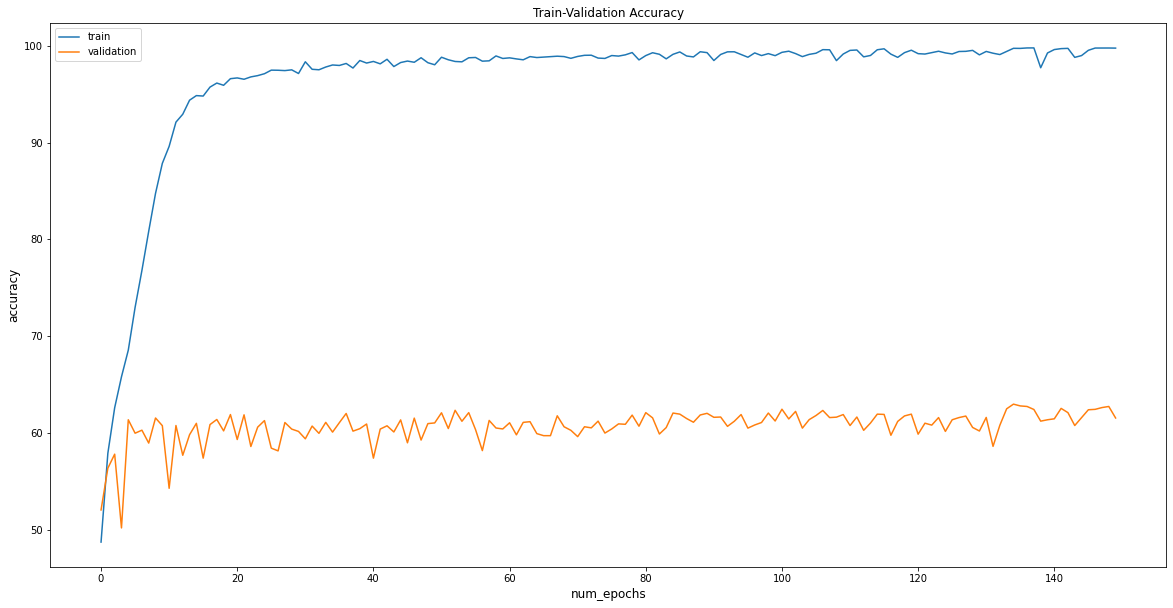

In [8]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

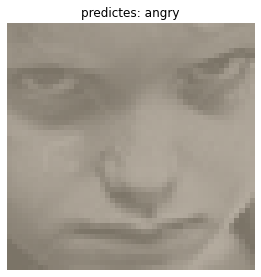

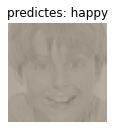

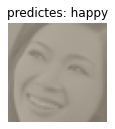

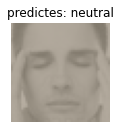

In [9]:
def visualize_model(net, num_images=4):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        if device:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if device else preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            ax.set_title('predictes: {}'.format(test_dataset.classes[preds[j]]))
            imshow(inputs[j])
            
            if images_so_far == num_images:
                return 

plt.ion()
visualize_model(net)
plt.ioff()